# Tutorial 2: Stop detection in trajectories

This notebook shows how to process device-level trajectory data, in different formats, to detect stops using ```nomad```. Stop detection is an important step in
pre-processing trajectory data and in making sense of trajectories by grouping together pings that reflect stationary behavior. The output of stop-detection algorithms is commonly a "stop table", indicating when a stop started, its duration, and a pair of coordinates that approximates the location of the group of pings (typically the centroid). Alternatively, ```nomad``` allows users to retrieve a cluster label for each ping (useful for plotting, for example)

In [347]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [348]:
%autoreload

In [349]:
import pandas as pd
import numpy as np
import math
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
from pathlib import Path
import sys
import os
import pdb
import pygeohash as gh
import geopandas as gpd

In [350]:
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
import nomad.filters as filters
import nomad.daphmeIO as loader
import nomad.constants as constants
import nomad.stop_detection.ta_dbscan as DBSCAN
import nomad.stop_detection.lachesis as Lachesis

## Load data sample

For these examples we load some test data from ```nomad``` which has the following trajectory columns (notice that ```traj_cols``` maps the data's column names to default names used by ```nomad```)

In [351]:
traj_cols = {'user_id':'uid',
             'datetime':'local_datetime'}

In [353]:
data = pd.read_csv("../nomad/data/gc_sample.csv")

# create tz_offset column
data['tz_offset'] = 0
data.loc[data.index[:5000],'tz_offset'] = -7200
data.loc[data.index[-5000:], 'tz_offset'] = 3600

# create string datetime column
data['local_datetime'] = loader._unix_offset_to_str(df.timestamp, df.tz_offset)
data['local_datetime'] = pd.to_datetime(data['local_datetime'], utc=True)

# create x, y columns in web mercator
gdf = gpd.GeoSeries(gpd.points_from_xy(data.longitude, data.latitude),
                        crs="EPSG:4326")
projected = gdf.to_crs("EPSG:3857")
data['x'] = projected.x
data['y'] = projected.y

data['geohash'] = df.apply(lambda x: gh.encode(x.latitude, x.longitude, precision=7), axis=1)

data.sample(5)

,uid,timestamp,latitude,longitude,tz_offset,local_datetime,x,y,geohash
18660,nervous_thompson,1704655440,38.320974,-36.667548,0,2024-01-07 19:24:00+00:00,-4.081813e+06,4.624868e+06,envfj85
18016,mystifying_chebyshev,1705061100,38.321036,-36.666326,0,2024-01-12 12:05:00+00:00,-4.081677e+06,4.624877e+06,envfj8h
16466,jolly_clarke,1705302120,38.320515,-36.666867,0,2024-01-15 07:02:00+00:00,-4.081737e+06,4.624803e+06,envfj8h
14457,festive_euler,1704600720,38.321091,-36.666732,0,2024-01-07 04:12:00+00:00,-4.081722e+06,4.624885e+06,envfj8h
16310,jolly_clarke,1704907860,38.320054,-36.667216,0,2024-01-10 17:31:00+00:00,-4.081776e+06,4.624738e+06,envcvxg


This synthetic data has records for 100 users for a 1 week period, with spherical coordinates (lat, lon) and datetime format for the time component of each ping. 

## Stop detection algorithms

The stop detection algorithms in ```nomad``` are applied to each user's trajectories separately. Thus, we demonstrate first by sampling a single user's data.

In [152]:
user_sample = data.loc[data.uid == "angry_spence"]
user_sample.head()

,uid,timestamp,latitude,longitude,tz_offset,local_datetime,x,y,geohash
24139,angry_spence,1704104460,38.320990,-36.666555,3600,2024-01-01 10:21:00+00:00,-4.081702e+06,4.624871e+06,envfj8h
24140,angry_spence,1704104820,38.320962,-36.666504,3600,2024-01-01 10:27:00+00:00,-4.081697e+06,4.624867e+06,envfj8h
24141,angry_spence,1704104940,38.320955,-36.666495,3600,2024-01-01 10:29:00+00:00,-4.081696e+06,4.624866e+06,envfj8h
24142,angry_spence,1704105540,38.320947,-36.666521,3600,2024-01-01 10:39:00+00:00,-4.081698e+06,4.624865e+06,envfj8h
24143,angry_spence,1704105720,38.320955,-36.666527,3600,2024-01-01 10:42:00+00:00,-4.081699e+06,4.624866e+06,envfj8h


For this user, the trajectory data has 1696 rows (pings) and covers a period of 15 days (start date: 2024-01-01, end date: 2024-01-15). We can visualize this trajectory below:

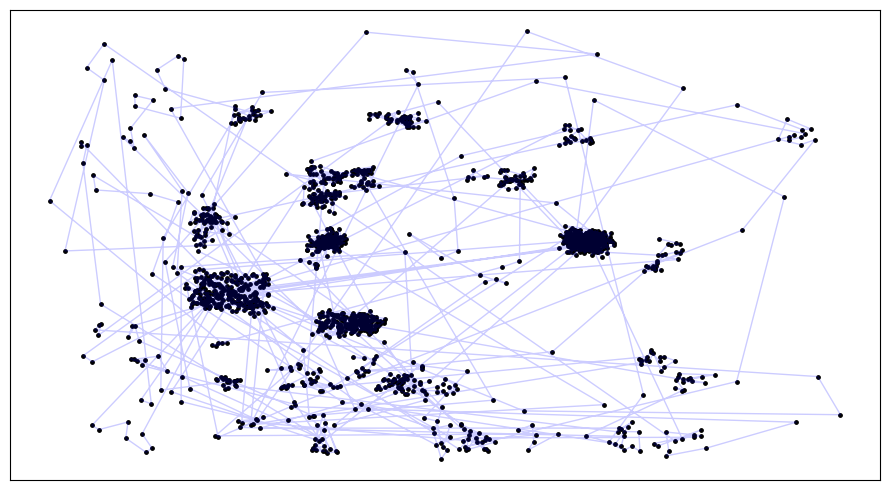

In [98]:
fig, ax = plt.subplots(figsize=(9, 5))

ax.scatter(x=user_sample['longitude'], 
           y=user_sample['latitude'],
           s=6,
           color='black',
           alpha=1,
           zorder=2)

ax.plot(user_sample['longitude'],
        user_sample['latitude'],
        linewidth=1, color='blue', alpha=0.2)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

### Sequential stop detection

The first stop detection algorithm implemented in ```nomad``` is a sequential algorithm insipired by the one in _Project Lachesis: Parsing and Modeling Location Histories_ (Hariharan & Toyama). This algorithm for extracting stays is dependent on two parameters: the roaming distance and the stay duration. 

* Roaming distance represents the maximum distance an object can move away from a point location and still be considered to be staying at that location.
* Stop duration is the minimum amount of time an object must spend within the roaming distance of a location to qualify as a stop.

The algorithm identifies stops as contiguous sequences of pings that stay within the roaming distance for at least the duration of the stop duration.

<div style="text-align: center;">
    <img src="lachesis_algo.png" alt="Lachesis Algorithm" title="Lachesis Algorithm" width="500">
</div>

This algorithm has the following parameters, which determine the size of the resulting stops:
* ```dur_min```: Minimum duration for a stay in minutes.
* ```dt_max```: Maximum time gap permitted between consecutive pings in a stay in minutes (dt_max should be greater than dur_min).
* ```delta_roam```: Maximum roaming distance for a stay in meters.

In [99]:
DUR_MIN = 60
DT_MAX = 120
DELTA_ROAM = 50

The Lachesis algorithm can output a complete table of attributes for identified stops, including the start time, end time, the medoid coordinates, duration, number of pings in the stop, and diameter.

In [138]:
%%time
Lachesis.lachesis(traj=user_sample,
                  dur_min=DUR_MIN,
                  dt_max=DT_MAX,
                  delta_roam=DELTA_ROAM,
                  traj_cols=traj_cols,
                  complete_output=True,
                  datetime='local_datetime',
                  latitude= 'latitude',
                  longitude='longitude').head()

CPU times: user 293 ms, sys: 15.6 ms, total: 309 ms
Wall time: 358 ms


,start_time,end_time,longitude,latitude,diameter,n_pings,duration
0,2024-01-01 15:04:00+00:00,2024-01-01 16:16:00+00:00,-36.66647,38.320064,14.691535,14,72.0
1,2024-01-01 18:17:00+00:00,2024-01-01 20:58:00+00:00,-36.667398,38.320415,12.974932,19,161.0
2,2024-01-01 21:15:00+00:00,2024-01-02 01:10:00+00:00,-36.667525,38.321253,13.946715,32,235.0
3,2024-01-02 05:54:00+00:00,2024-01-02 08:01:00+00:00,-36.667489,38.321273,31.46013,17,127.0
4,2024-01-02 08:40:00+00:00,2024-01-02 11:59:00+00:00,-36.667721,38.320554,20.736412,39,199.0


An additional argument, ```complete_output```, can be passed to only output the stop start time, duration, and medoid coordinates.

In [172]:
%%time
Lachesis.lachesis(traj=user_sample,
                  dur_min=DUR_MIN,
                  dt_max=DT_MAX,
                  delta_roam=DELTA_ROAM,
                  traj_cols=traj_cols,
                  complete_output=False,
                  datetime='local_datetime',
                  latitude='latitude',
                  longitude='longitude').head()

CPU times: user 256 ms, sys: 17 ms, total: 273 ms
Wall time: 336 ms


,start_time,duration,longitude,latitude
0,2024-01-01 15:04:00+00:00,72.0,-36.66647,38.320064
1,2024-01-01 18:17:00+00:00,161.0,-36.667398,38.320415
2,2024-01-01 21:15:00+00:00,235.0,-36.667525,38.321253
3,2024-01-02 05:54:00+00:00,127.0,-36.667489,38.321273
4,2024-01-02 08:40:00+00:00,199.0,-36.667721,38.320554


We can also get the final cluster label for each of the pings, including those who were identified as noise.

In [290]:
%%time
sample_labels_lach = Lachesis._lachesis_labels(traj=user_sample,
                          dur_min=DUR_MIN,
                          dt_max=DT_MAX,
                          delta_roam=DELTA_ROAM,
                          traj_cols=traj_cols,
                          datetime='local_datetime')
sample_labels_lach.sample(n=5)

CPU times: user 137 ms, sys: 5.28 ms, total: 142 ms
Wall time: 141 ms


,cluster
2024-01-11 01:04:00+00:00,34
2024-01-07 14:07:00+00:00,23
2024-01-06 09:35:00+00:00,18
2024-01-08 03:50:00+00:00,24
2024-01-02 13:43:00+00:00,-1


The data could also come with different formats for spatial and temporal variables, the algorithm can handle those situations as well.

In [142]:
%%time
# Lachesis with x, y, and timestamp
Lachesis.lachesis(traj=user_sample,
                  dur_min=DUR_MIN,
                  dt_max=DT_MAX,
                  delta_roam=DELTA_ROAM,
                  traj_cols=traj_cols,
                  complete_output=False,
                  timestamp='timestamp',
                  x='x',
                  y='y').head()

CPU times: user 95.4 ms, sys: 10.3 ms, total: 106 ms
Wall time: 137 ms


,start_time,duration,x,y
0,1.704121e+09,72.0,-4.081693e+06,4.624739e+06
1,1.704133e+09,161.0,-4.081796e+06,4.624789e+06
2,1.704144e+09,235.0,-4.081810e+06,4.624908e+06
3,1.704175e+09,127.0,-4.081806e+06,4.624911e+06
4,1.704185e+09,199.0,-4.081832e+06,4.624809e+06


Here we demonstrate how we can apply our stop detection algorithm to multiple users by using ```groupby``` and ```apply```:

In [154]:
mult_users = data.loc[data.uid.isin(["angry_spence", "stoic_almeida", "relaxed_colden", "dazzling_bassi"])]
mult_users.sample(5)

,uid,timestamp,latitude,longitude,tz_offset,local_datetime,x,y,geohash
25363,angry_spence,1704951480,38.320968,-36.666809,3600,2024-01-11 05:38:00+00:00,-4.081731e+06,4.624868e+06,envfj8h
3694,dazzling_bassi,1704251400,38.320961,-36.666763,-7200,2024-01-03 03:10:00+00:00,-4.081725e+06,4.624867e+06,envfj8h
24225,angry_spence,1704176280,38.321279,-36.667473,3600,2024-01-02 06:18:00+00:00,-4.081804e+06,4.624912e+06,envfj85
24458,angry_spence,1704332940,38.321368,-36.667479,3600,2024-01-04 01:49:00+00:00,-4.081805e+06,4.624924e+06,envfj85
3887,dazzling_bassi,1705139460,38.320156,-36.667746,-7200,2024-01-13 09:51:00+00:00,-4.081835e+06,4.624752e+06,envcvxg


In [156]:
%%time
mult_users.groupby(['uid']).apply(lambda x: Lachesis.lachesis(x.reset_index(),
                                                                  dur_min=DUR_MIN,
                                                                  dt_max=DT_MAX,
                                                                  delta_roam=DELTA_ROAM,
                                                                  traj_cols=traj_cols,
                                                                  complete_output=True),include_groups=False)

CPU times: user 112 ms, sys: 2.67 ms, total: 115 ms
Wall time: 118 ms


start_time      end_time             x             y  \
uid                                                                         
angry_spence   0   1.704121e+09  1.704126e+09 -4.081693e+06  4.624739e+06   
               1   1.704133e+09  1.704143e+09 -4.081796e+06  4.624789e+06   
               2   1.704144e+09  1.704158e+09 -4.081810e+06  4.624908e+06   
               3   1.704175e+09  1.704182e+09 -4.081806e+06  4.624911e+06   
               4   1.704185e+09  1.704197e+09 -4.081832e+06  4.624809e+06   
...                         ...           ...           ...           ...   
relaxed_colden 13  1.705256e+09  1.705286e+09 -4.081736e+06  4.624926e+06   
stoic_almeida  0   1.704164e+09  1.704174e+09 -4.081730e+06  4.624811e+06   
               1   1.704747e+09  1.704754e+09 -4.081727e+06  4.624819e+06   
               2   1.705053e+09  1.705059e+09 -4.081704e+06  4.624736e+06   
               3   1.705290e+09  1.705300e+09 -4.081727e+06  4.624818e+06   

                    diameter  n_pings  duration  
uid                                              
angry_spence   0   17.856507     14.0      72.0  
               1   16.042134     19.0     161.0  
               2   16.688110     32.0     235.0  
               3   49.278754     17.0     127.0  
               4   29.123634     39.0     199.0  
...                      ...      ...       ...  
relaxed_colden 13  21.274880     64.0     511.0  
stoic_almeida  0   13.054856      5.0     152.0  
               1   11.978962      4.0     118.0  
               2   18.937556      3.0     101.0  
               3   16.949260      5.0     154.0  

[83 rows x 7 columns]

In [326]:
# merged_data_lach = user_sample.merge(sample_labels_lach[['cluster']], 
#                                      left_on='local_datetime',
#                                      right_index=True)

# unique_clusters = np.sort(merged_data_lach['cluster'].unique())
# cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}
# mapped_clusters = merged_data_lach['cluster'].map(cluster_mapping).to_numpy()
# cmap_base = plt.get_cmap('turbo', len(unique_clusters) - (1 if -1 in unique_clusters else 0))
# colors = ['gray'] + list(cmap_base.colors)
# extended_cmap = mcolors.ListedColormap(colors)

# fig, ax = plt.subplots(figsize=(10, 5))
# sc = ax.scatter(merged_data_lach['longitude'], 
#                 merged_data_lach['latitude'], 
#                 c=mapped_clusters, 
#                 cmap=extended_cmap, 
#                 s=6,
#                 alpha=1,
#                 zorder=2)

# cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', label='Cluster ID')

# tick_vals = list(cluster_mapping.values())
# tick_labels = list(cluster_mapping.keys())
# cbar.set_ticks(tick_vals)
# cbar.set_ticklabels(tick_labels)

# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_title("Lachesis Stops for Sample User")
# plt.tight_layout()
# plt.show()

### Density based stop detection (Temporal DBSCAN)

The second stop detection algorithm implemented in ```nomad``` is a time-augmented density-based algorithm, Temporal DBSCAN. This algorithm for clustering user pings combines temporal and spatial dimensions, relying on three key parameters: the time threshold, the distance threshold, and the minimum number of points.

* The time threshold defines the maximum time difference (in minutes) between two consecutive pings for them to be considered neighbors within the same cluster.
* The distance threshold specifies the maximum spatial distance (in meters) between two pings for them to be considered neighbors.
* The minimum points parameter sets the minimum number of points required for a dense region to form a cluster.

If a region contains fewer than minimum number of points required, it is treated as noise. The algorithm identifies clusters by grouping contiguous pings that meet both the temporal and spatial criteria, while also ensuring that each cluster has enough density to be considered valid. Our implementation of Temporal DBSCAN recursively processes the clusters obtained from DBSCAN to address the issue of some clusters overlapping in time.

<div style="text-align: center;">
    <img src="dbscan_algo.png" alt="DBSCAN Algorithm" title="DBSCAN Algorithm" width="500">
</div>

This algorithm has the following parameters, which determine the size of the resulting stops:
* ```time_thresh```: Time threshold in minutes for identifying neighbors.
* ```dist_thresh```: Distance threshold in meters for identifying neighbors.
* ```min_pts```: Minimum number of points required to form a dense region (core point).

In [286]:
TIME_THRESH = 100
DIST_THRESH = 40
MIN_PTS = 10

Similarly to Lachesis, the Temporal DBSCAN algorithm can output a complete table of attributes for identified stops, including the start time, end time, the medoid coordinates, duration, number of pings in the stop, and diameter.

In [287]:
%%time
DBSCAN.temporal_dbscan(user_sample,
                       time_thresh=TIME_THRESH,
                       dist_thresh=DIST_THRESH,
                       min_pts=MIN_PTS,
                       traj_cols=traj_cols,
                       complete_output=True,
                       datetime='local_datetime',
                       latitude='latitude',
                       longitude='longitude').head()

CPU times: user 14.1 s, sys: 735 ms, total: 14.8 s
Wall time: 15.1 s


,start_time,end_time,longitude,latitude,diameter,n_pings,duration
cluster,,,,,,,
0,2024-01-04 16:02:00+00:00,2024-01-04 16:45:00+00:00,-0.639973,0.668841,11.374422,14,43.0
1,2024-01-14 19:45:00+00:00,2024-01-15 07:39:00+00:00,-0.639968,0.668818,22.775558,87,714.0
2,2024-01-14 14:10:00+00:00,2024-01-14 15:39:00+00:00,-0.639963,0.668810,14.062991,13,89.0
3,2024-01-14 01:45:00+00:00,2024-01-14 07:52:00+00:00,-0.639956,0.668827,13.814779,57,367.0
4,2024-01-13 13:53:00+00:00,2024-01-13 16:45:00+00:00,-0.639952,0.668824,61.588256,18,172.0


The additional argument ```complete_output``` can also be passed to only output the stop start time, duration, and medoid coordinates.

In [186]:
%%time
DBSCAN.temporal_dbscan(user_sample,
                       time_thresh=TIME_THRESH,
                       dist_thresh=DIST_THRESH,
                       min_pts=MIN_PTS,
                       traj_cols=traj_cols,
                       complete_output=False,
                       datetime='local_datetime',
                       latitude='latitude',
                       longitude='longitude').head()

CPU times: user 14 s, sys: 736 ms, total: 14.8 s
Wall time: 15 s


,start_time,duration,longitude,latitude
cluster,,,,
0,2024-01-04 16:02:00+00:00,43.0,-0.639973,0.668841
1,2024-01-14 19:45:00+00:00,714.0,-0.639968,0.668818
2,2024-01-14 14:10:00+00:00,89.0,-0.639963,0.668810
3,2024-01-14 01:45:00+00:00,367.0,-0.639956,0.668827
4,2024-01-13 13:53:00+00:00,172.0,-0.639952,0.668824


We can also get the final cluster and core labels for each of the pings.

In [294]:
%%time
sample_labels_dbscan = DBSCAN._temporal_dbscan_labels(user_sample,
                                                      time_thresh=TIME_THRESH,
                                                      dist_thresh=DIST_THRESH,
                                                      min_pts=MIN_PTS,
                                                      traj_cols=traj_cols,
                                                      datetime='local_datetime',
                                                      latitude='latitude',
                                                      longitude='longitude')

sample_labels_dbscan.sample(5)

CPU times: user 13.6 s, sys: 550 ms, total: 14.2 s
Wall time: 14.3 s


,cluster,core
2024-01-04 19:59:00+00:00,35,35
2024-01-12 21:12:00+00:00,6,6
2024-01-06 05:37:00+00:00,30,30
2024-01-13 03:56:00+00:00,6,6
2024-01-10 21:29:00+00:00,14,14


The Temporal DBSCAN algorithm also handles data that comes with different formats for spatial and temporal variables.

In [189]:
%%time
# Temporal DBSCAN with x, y, and timestamp
DBSCAN.temporal_dbscan(user_sample,
                       time_thresh=TIME_THRESH,
                       dist_thresh=DIST_THRESH,
                       min_pts=MIN_PTS,
                       traj_cols=traj_cols,
                       complete_output=True,
                       timestamp='timestamp',
                       x='x',
                       y='y').head()

CPU times: user 3.48 s, sys: 572 ms, total: 4.05 s
Wall time: 4.13 s


,start_time,end_time,x,y,diameter,n_pings,duration
cluster,,,,,,,
0,1.704384e+09,1.704387e+09,-4.081836e+06,4.624984e+06,16.842346,14.0,43.0
1,1.705262e+09,1.705304e+09,-4.081802e+06,4.624791e+06,24.657644,87.0,714.0
2,1.705241e+09,1.705247e+09,-4.081771e+06,4.624728e+06,15.230095,13.0,89.0
3,1.705197e+09,1.705219e+09,-4.081725e+06,4.624865e+06,21.113292,57.0,367.0
4,1.705158e+09,1.705164e+09,-4.081703e+06,4.624845e+06,22.983725,17.0,99.0


In [327]:
# merged_data_dbscan = user_sample.merge(sample_labels_dbscan[['cluster']], 
#                                      left_on='local_datetime',
#                                      right_index=True)

# unique_clusters = np.sort(merged_data_dbscan['cluster'].unique())
# cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}
# mapped_clusters = merged_data_dbscan['cluster'].map(cluster_mapping).to_numpy()
# cmap_base = plt.get_cmap('turbo', len(unique_clusters) - (1 if -1 in unique_clusters else 0))
# colors = ['gray'] + list(cmap_base.colors)
# extended_cmap = mcolors.ListedColormap(colors)

# fig, ax = plt.subplots(figsize=(10, 5))
# sc = ax.scatter(merged_data_dbscan['longitude'], 
#                 merged_data_dbscan['latitude'], 
#                 c=mapped_clusters, 
#                 cmap=extended_cmap, 
#                 s=6,
#                 alpha=1,
#                 zorder=2)

# cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', label='Cluster ID')

# tick_vals = list(cluster_mapping.values())
# tick_labels = list(cluster_mapping.keys())
# cbar.set_ticks(tick_vals)
# cbar.set_ticklabels(tick_labels)

# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# ax.set_title("DBSCAN Stops for Sample User")

# plt.tight_layout()
# plt.show()

In [298]:
import nomad.city_gen as cg
city = cg.load('garden-city.pkl')

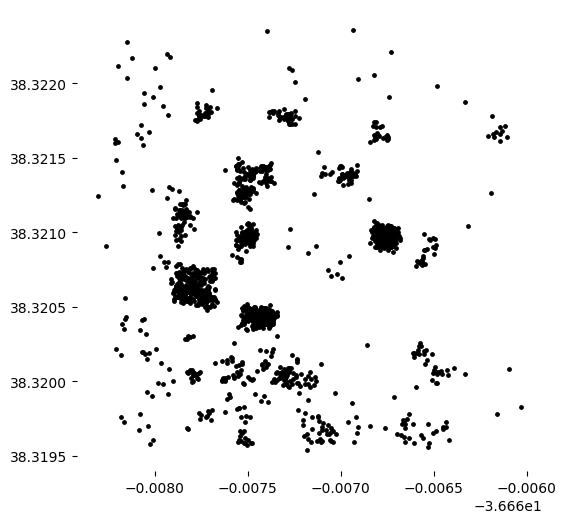

In [346]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=False)

# city.plot_city(ax, doors=True, address=False)


ax.scatter(x=user_sample['longitude'], 
           y=user_sample['latitude'],
           s=6,
           color='black',
           alpha=1,
           zorder=2)

# ax.plot(user_sample['longitude'],
#         user_sample['latitude'],
#         linewidth=1, color='blue', alpha=0.2)

# ax.set_yticklabels([])
# ax.set_xticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

plt.savefig('gc_empty.png')
plt.show()